Simulated Data GP Example

In [1]:
# Setup
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp

# Options
%matplotlib inline

In [2]:
%%latex 
\begin{gather*}
\text{Data generation process}: \\
\text{For each individual}: \\
\text{Disease Severity}: s_p \sim Gamma(1, 1) \\\\
\text{For each time point}: \\
\text{T_offset}: x_t \sim Exp(0.1) \\
\text{Disease Status}: x_d \sim \chi^2(s_p) \\\\
\sigma^2_d = 1, c_d = 0, \text{offset}_d = 1, p_d = 3 \\
K(x,x')_d = \sigma^2_d((x-c_d)(x'-c_d) + \text{offset}_d)^{p_d} \\
\sigma^2_t = 1, \ell_t = 1 \\
%K(x,x')_t = \sigma^2_t\text{exp}\left[-\frac{(x-x')^2}{\ell_t} \right] \\

\text{Metabolite} \sim N(\mu, \sigma)
\end{gather*}

<IPython.core.display.Latex object>

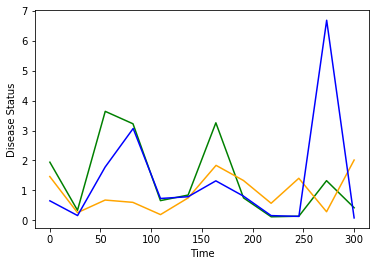

In [3]:
np.random.seed(9102)
p = 3
n = 12
days = 300
dx_rate = np.random.gamma(shape = 2, scale = 1, size = p)
X_multi = np.vstack([np.tile(np.linspace(0,days,n), p) + np.random.exponential(0.1, size = n*p), 
#            np.random.chisquare(2,p*n), 
           np.concatenate([np.random.exponential(dx_rate[i], n) for i in np.arange(p)]),
           np.repeat(np.arange(p), n)]).T

# Standardize data
X_multi_org = X_multi.copy()
X_multi[:,:2] = (X_multi[:,:2]-X_multi[:,:2].mean(axis=0))/X_multi[:,:2].std(axis=0)

# Plot data
p_cols = ['green', 'orange', 'blue']
for p_ in np.arange(p):
    plt.plot(X_multi_org[X_multi[:,2] == p_, 0],
             X_multi_org[X_multi[:,2] == p_, 1],
             color = p_cols[p_])
plt.xlabel('Time')
plt.ylabel('Disease Status')
    
id_matrix = np.zeros(shape = (len(X_multi[:,2]), p))
id_matrix[np.arange(n*p),X_multi[:,2].astype(int)] = 1
id_matrix

X_multi_dummy = np.hstack((X_multi[:,:2], id_matrix))

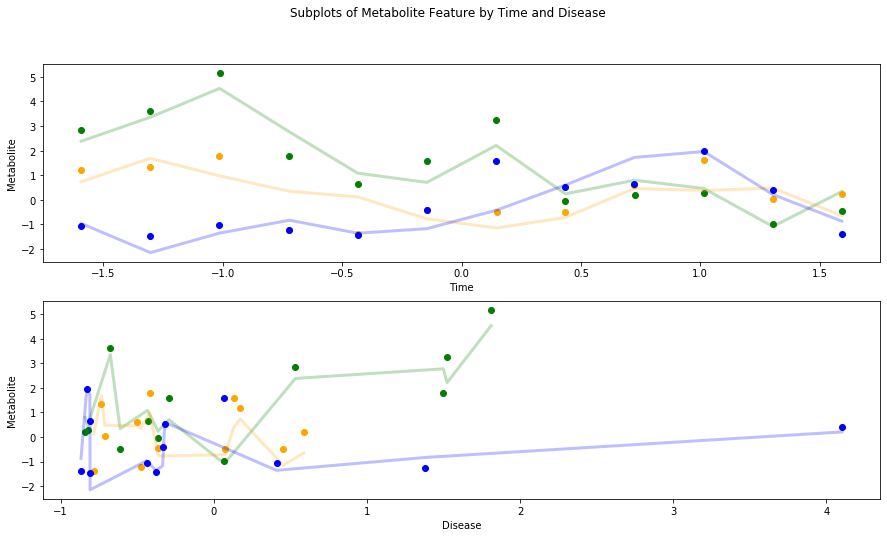

In [4]:
# Build data
np.random.seed(9102)

# Data generation covariance function
cd_true = 0.0
dd_true = 2.0
od_true = 1.0
sig2d_true = 1.0#2.0
lt_true = 0.5
sig2t_true = 1.0
sig2i_true = 1.0#2.0
li_true = [0.02, 0.4, 1]
sig2dt = 4.0
ldt1_true = 3.0
ldt2_true = 0.5
dis_func = sig2d_true * pm.gp.cov.Polynomial(5, cd_true, dd_true, 
                                              offset = od_true, active_dims = [1]) 
time_func = sig2t_true * pm.gp.cov.ExpQuad(5, lt_true, active_dims = [0])
id_func = sig2i_true * pm.gp.cov.ExpQuad(5, li_true, active_dims = [2,3,4])
dt_func = (sig2dt * pm.gp.cov.ExpQuad(5, ldt1_true, active_dims = [0])*
           pm.gp.cov.ExpQuad(5, ldt2_true, active_dims = [1]))
cov_func = id_func * (dis_func + time_func) #+ dt_func #+ id_func

# Zero mean function
mean_func = pm.gp.mean.Zero()

# Draw samples from GP    
f_true = np.random.multivariate_normal(
    mean_func(X_multi_dummy).eval(), cov_func(X_multi_dummy).eval() + 1e-8 * np.eye(n*p), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
sig2n_true = 1.0
y = f_true + sig2n_true * np.random.randn(n*p)

# Output data
X_out = np.hstack((f_true[:, None], y[:, None], X_multi))

## Plot the data and the unobserved latent function
# fig = plt.figure(figsize=(12, 5))
# ax = fig.gca()

# for p_ in np.arange(p):
#     ax.plot(X_out[X_out[:,4] == p_, 2],
#             X_out[X_out[:,4] == p_, 0],
#             lw = 3, color = p_cols[p_])
#     ax.plot(X_out[X_out[:,4] == p_, 2],
#              X_out[X_out[:,4] == p_, 1],
#             'o', color = p_cols[p_])
# # ax.plot(X[:,0], f_true, "dodgerblue", lw=3, label="True f")
# # ax.plot(X[:,0], y, "ok", ms=3, alpha=0.5, label="Data")
# ax.set_xlabel("Time")
# ax.set_ylabel("Metabolite");

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,8))
fig.suptitle('Subplots of Metabolite Feature by Time and Disease')

for p_ in np.arange(p):
    X_sub = X_out[X_out[:,4] == p_]
    ax1.plot(X_sub[:,2], X_sub[:,0],
             lw=3, color=p_cols[p_],
             alpha=0.25)
    ax1.plot(X_sub[:,2], X_sub[:,1], 
             "o", color=p_cols[p_])
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Metabolite")

    # Sort data by disease level
    X_sub_sort = X_sub[np.argsort(X_sub[:,3])]
    ax2.plot(X_sub_sort[:,3], 
             X_sub_sort[:,0],
             lw=3, color=p_cols[p_], 
             alpha=0.25)
    ax2.plot(X_sub_sort[:,3],
             X_sub_sort[:,1],
             "o", color=p_cols[p_])
    ax2.set_xlabel("Disease")
    ax2.set_ylabel("Metabolite")
    
plt.show();

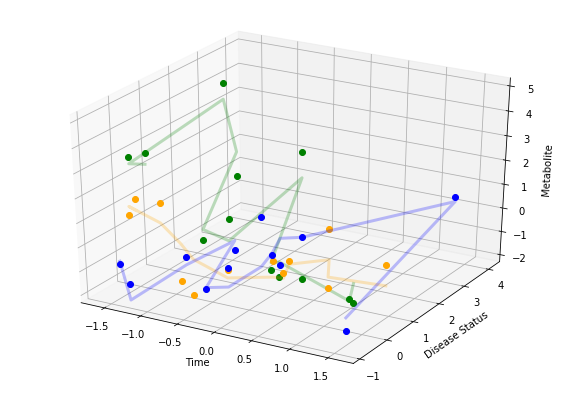

In [7]:
from mpl_toolkits.mplot3d import Axes3D
plt3d = plt.figure(figsize=(10,7)).gca(projection='3d')

for p_ in np.arange(p):
    X_sub = X_out[X_out[:,4] == p_]
    plt3d.plot(X_sub[:,2],
               X_sub[:,3],
               X_sub[:,0],
               lw=3, 
               color=p_cols[p_],
               alpha=0.25)
    plt3d.plot(X_sub[:,2], 
               X_sub[:,3],
               X_sub[:,1], 
               "o", 
               color=p_cols[p_])
    plt3d.set_xlabel('Time')
    plt3d.set_ylabel('Disease Status')
    plt3d.set_zlabel('Metabolite')

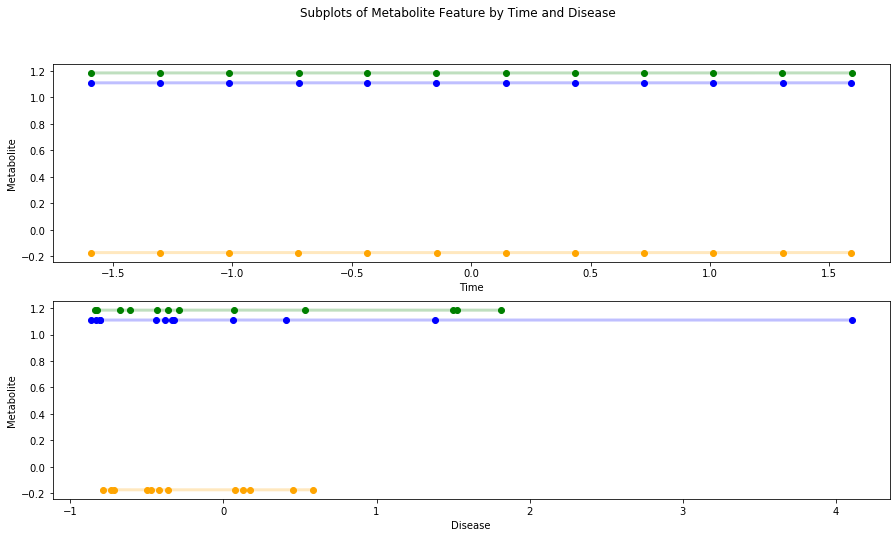

In [8]:
# Draw samples from each individual component
f_id = np.random.multivariate_normal(
    mean_func(X_multi_dummy).eval(), id_func(X_multi_dummy).eval() + 1e-8 * np.eye(n*p), 1
).flatten()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,8))
fig.suptitle('Subplots of Metabolite Feature by Time and Disease')

for p_ in np.arange(p):
    X_sub = X_out_uni[X_out[:,4] == p_]
    ax1.plot(X_sub[:,2], X_sub[:,0],
             lw=3, color=p_cols[p_],
             alpha=0.25)
    ax1.plot(X_sub[:,2], X_sub[:,1], 
             "o", color=p_cols[p_])
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Metabolite")

    # Sort data by disease level
    X_sub_sort = X_sub[np.argsort(X_sub[:,3])]
    ax2.plot(X_sub_sort[:,3], 
             X_sub_sort[:,0],
             lw=3, color=p_cols[p_], 
             alpha=0.25)
    ax2.plot(X_sub_sort[:,3],
             X_sub_sort[:,1],
             "o", color=p_cols[p_])
    ax2.set_xlabel("Disease")
    ax2.set_ylabel("Metabolite")
    
plt.show();

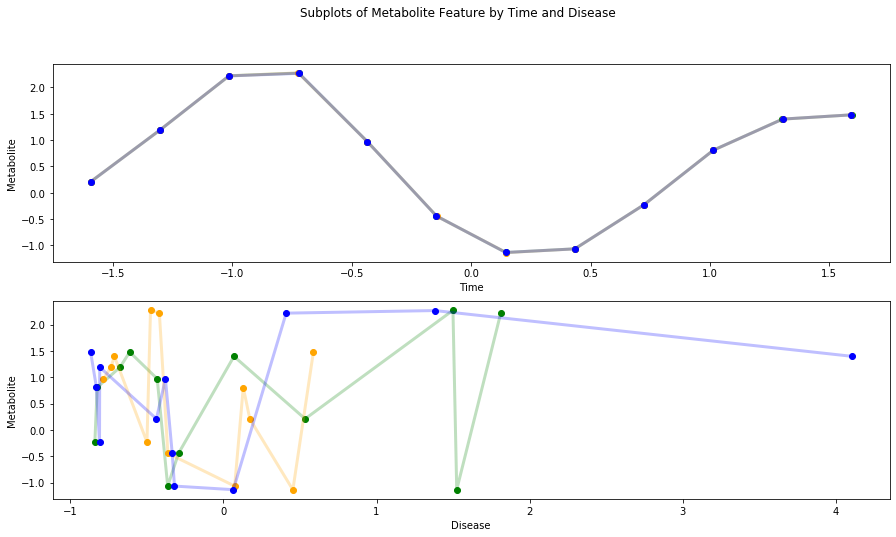

In [9]:
# Draw samples from each individual component
f_id = np.random.multivariate_normal(
    mean_func(X_multi_dummy).eval(), time_func(X_multi_dummy).eval() + 1e-8 * np.eye(n*p), 1
).flatten()

# Output data
X_out_uni = np.hstack((f_id[:, None], f_id[:, None], X_multi))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,8))
fig.suptitle('Subplots of Metabolite Feature by Time and Disease')

for p_ in np.arange(p):
    X_sub = X_out_uni[X_out[:,4] == p_]
    ax1.plot(X_sub[:,2], X_sub[:,0],
             lw=3, color=p_cols[p_],
             alpha=0.25)
    ax1.plot(X_sub[:,2], X_sub[:,1], 
             "o", color=p_cols[p_])
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Metabolite")

    # Sort data by disease level
    X_sub_sort = X_sub[np.argsort(X_sub[:,3])]
    ax2.plot(X_sub_sort[:,3], 
             X_sub_sort[:,0],
             lw=3, color=p_cols[p_], 
             alpha=0.25)
    ax2.plot(X_sub_sort[:,3],
             X_sub_sort[:,1],
             "o", color=p_cols[p_])
    ax2.set_xlabel("Disease")
    ax2.set_ylabel("Metabolite")
    
plt.show();

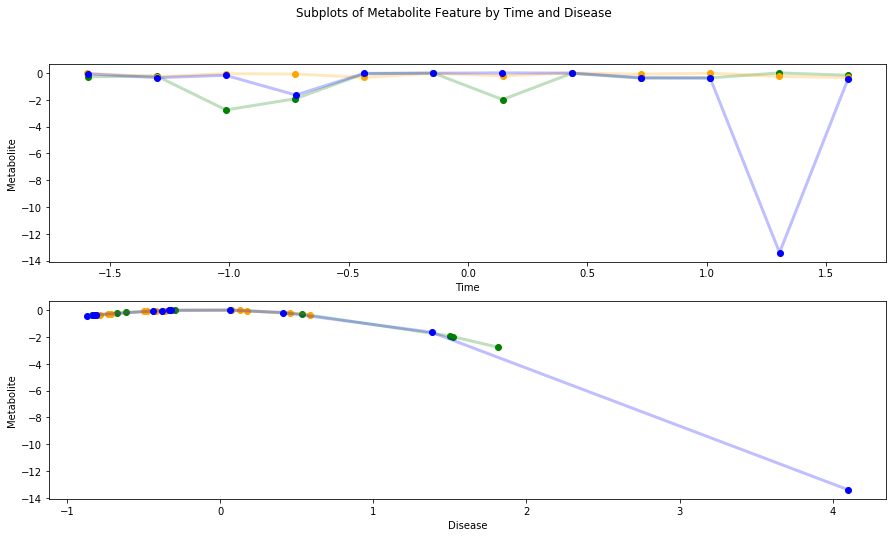

In [10]:
# Draw samples from each individual component
f_id = np.random.multivariate_normal(
    mean_func(X_multi_dummy).eval(), dis_func(X_multi_dummy).eval() + 1e-8 * np.eye(n*p), 1
).flatten()

# Output data
X_out_uni = np.hstack((f_id[:, None], f_id[:, None], X_multi))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,8))
fig.suptitle('Subplots of Metabolite Feature by Time and Disease')

for p_ in np.arange(p):
    X_sub = X_out_uni[X_out[:,4] == p_]
    ax1.plot(X_sub[:,2], X_sub[:,0],
             lw=3, color=p_cols[p_],
             alpha=0.25)
    ax1.plot(X_sub[:,2], X_sub[:,1], 
             "o", color=p_cols[p_])
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Metabolite")

    # Sort data by disease level
    X_sub_sort = X_sub[np.argsort(X_sub[:,3])]
    ax2.plot(X_sub_sort[:,3], 
             X_sub_sort[:,0],
             lw=3, color=p_cols[p_], 
             alpha=0.25)
    ax2.plot(X_sub_sort[:,3],
             X_sub_sort[:,1],
             "o", color=p_cols[p_])
    ax2.set_xlabel("Disease")
    ax2.set_ylabel("Metabolite")
    
plt.show();

Build Model

In [11]:
# Specify model
with pm.Model() as model:
    
    # Priors (0, 1, 3)
    c = pm.Normal('c', mu = 0, sigma = 1)
    offset = pm.Lognormal('offset', mu = 0, sigma = 1)
    poly = pm.Poisson('poly', mu = 0.5)#pm.Uniform('poly', lower = 1, upper = 3)
    
    l_t = pm.Lognormal('l_t', mu = 0, sigma = 0.1)
    l_p = pm.Lognormal('l_p', mu = 0, sigma = 0.1, shape = 3)
    
    sigma2_d = pm.Lognormal('sigma2_d', mu = 0, sigma = 1)
    sigma2_t = pm.Lognormal('sigma2_t', mu = 0, sigma = 1)
    sigma2_i = pm.Lognormal('sigma2_i', mu = 0, sigma = 1)
    #sigma2_dt = pm.Lognormal('sigma2_dt', mu=0, sigma=1)
#     sigma2_f = pm.Lognormal('sigma2_f', mu = 0, sigma = 1, shape = 3)
    
    # Covariance function
    cov_fun = ((sigma2_d*pm.gp.cov.Polynomial(5, c, poly, offset = offset, active_dims = [1]) + 
                sigma2_t*pm.gp.cov.ExpQuad(5, l_t, active_dims = [0]) *#+ 
                sigma2_i*pm.gp.cov.ExpQuad(5, l_p, active_dims = [2,3,4]))) #+ 
#                sigma2_dt*pm.gp.cov.Polynomial(5, c, poly, offset = offset, active_dims = [1])*pm.gp.cov.ExpQuad(5, l_p, active_dims = [2,3,4]))
    
    # GP
    gp = pm.gp.Marginal(cov_func = cov_fun)
    
    
    # Likelihood
    sigma2_n = pm.Lognormal('s2_n', mu = 0, sigma = 1)
    y_obs = gp.marginal_likelihood('y_obs', noise = sigma2_n, X = X_multi_dummy, y = y[:, None].squeeze())
    

In [12]:
with model:
    gp_trace = pm.sample()

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [s2_n, sigma2_i, sigma2_t, sigma2_d, l_p, l_t, offset, c]
>Metropolis: [poly]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
c,-0.023,0.988,-1.897,1.741,0.020,0.024,2406.0,867.0,2406.0,1521.0,1.0
poly,0.250,0.447,0.000,1.000,0.022,0.016,406.0,406.0,408.0,394.0,1.0
offset,1.513,1.817,0.027,4.450,0.043,0.032,1806.0,1605.0,2783.0,1489.0,1.0
l_t,0.992,0.097,0.817,1.177,0.002,0.001,3055.0,2900.0,3174.0,1446.0,1.0
l_p[0],0.999,0.099,0.812,1.186,0.002,0.001,2505.0,2473.0,2514.0,1288.0,1.0
l_p[1],1.011,0.100,0.840,1.217,0.002,0.002,2269.0,2151.0,2339.0,1131.0,1.0
l_p[2],0.991,0.099,0.802,1.164,0.002,0.001,2595.0,2479.0,2568.0,1392.0,1.0
sigma2_d,1.127,1.305,0.034,3.260,0.030,0.023,1849.0,1625.0,2617.0,1321.0,1.0
sigma2_t,2.017,1.813,0.149,4.939,0.045,0.034,1625.0,1402.0,1930.0,1455.0,1.0
sigma2_i,2.082,1.904,0.185,5.075,0.047,0.034,1615.0,1614.0,2016.0,1422.0,1.0


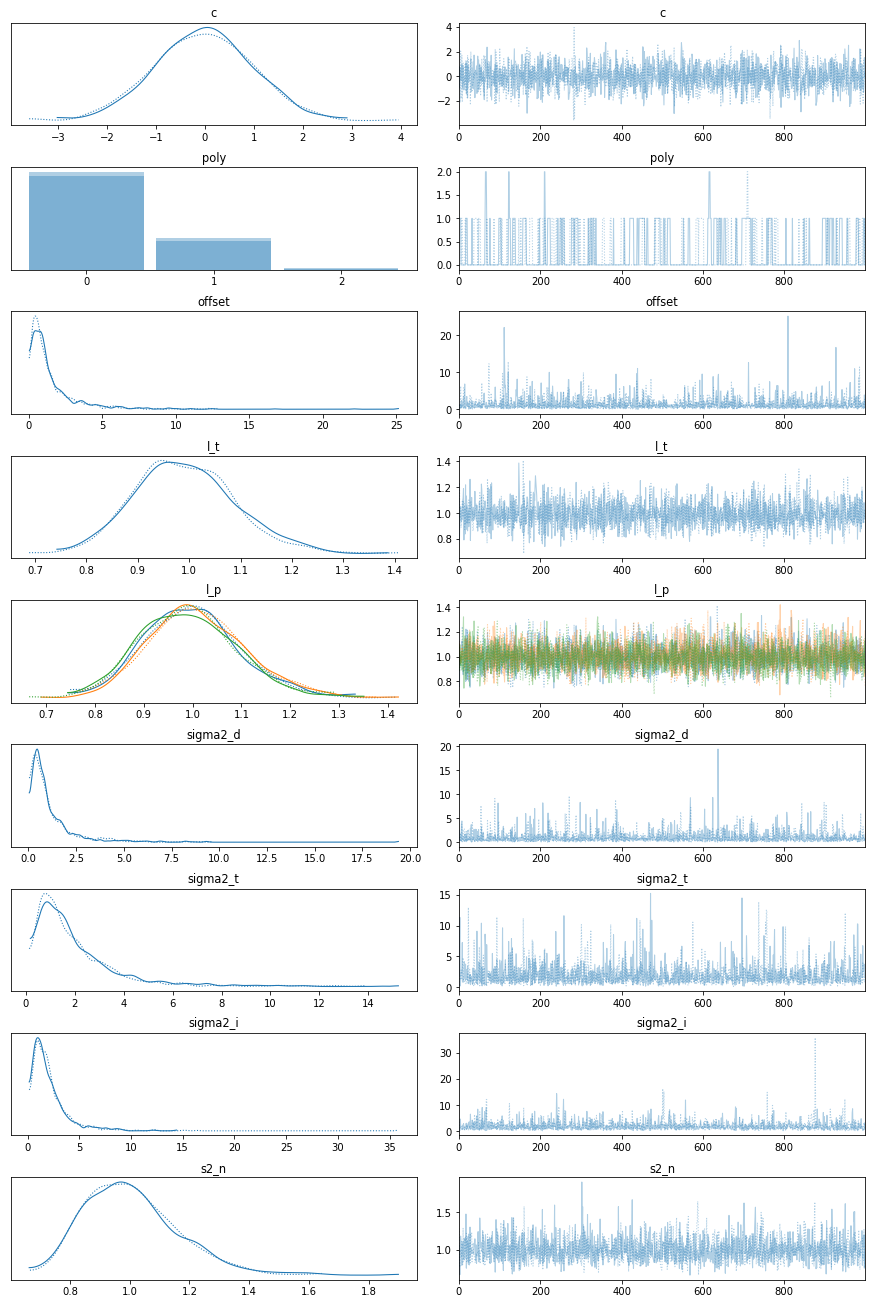

In [13]:
pm.traceplot(gp_trace)
pm.summary(gp_trace)

In [130]:
with model:
    # First get the conditional function values given posterior
    f_pred_obs = gp.conditional('f_pred_obs', X_multi_dummy)
    
    # Now get the predictive distribution
    pred_obs_samples = pm.sample_posterior_predictive(gp_trace, 
                                                  var_names = ['f_pred_obs'],
                                                  random_seed = 1)

In [134]:
pred_obs_samples['f_pred_obs']

array([[ 3.26244821,  2.03340732,  0.45699009, ..., -0.10316014,
         0.31707554,  1.19686478],
       [ 3.51261519,  2.69600673,  1.5713945 , ...,  1.2038858 ,
         0.96563075,  0.87731388],
       [ 3.23129514,  2.58444602,  1.21018017, ...,  0.26308343,
         0.57027514,  1.07168358],
       ...,
       [ 3.00219254,  2.40355099,  0.23347293, ...,  0.90707639,
        -0.77895202,  1.5115841 ],
       [ 3.2138283 ,  2.60593295,  0.82752705, ...,  1.23228749,
        -0.02073319,  0.49377401],
       [ 3.29151181,  2.72986112,  0.84114608, ...,  0.33394968,
        -0.22216916,  1.62878995]])

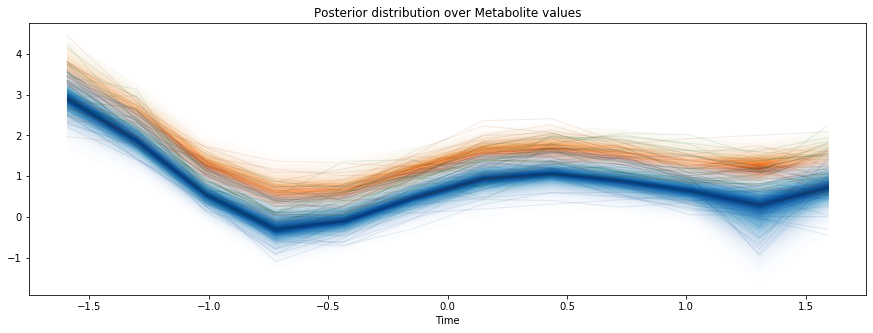

In [139]:
# Plotting 
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

# Plot over time with no disease status
plot_gp_dist(ax, 
             pred_obs_samples["f_pred_obs"][:,X_multi_dummy[:,2]==1], 
             X_multi_dummy[X_multi_dummy[:,2]==1,0],
             palette = 'Greens',
             fill_alpha = 0.5)
plot_gp_dist(ax, 
             pred_obs_samples["f_pred_obs"][:,X_multi_dummy[:,3]==1], 
             X_multi_dummy[X_multi_dummy[:,3]==1,0],
             palette = 'Oranges',
             fill_alpha = 0.25)
plot_gp_dist(ax, 
             pred_obs_samples["f_pred_obs"][:,X_multi_dummy[:,4]==1], 
             X_multi_dummy[X_multi_dummy[:,4]==1,0],
             palette = 'Blues',
             fill_alpha = 0.25)

# # Overlay observed data
# sns.scatterplot(data = df_sub.assign(id = df_sub_id.id),
#                 x = 'days_from_start',
#                 y = 'scaled_log_intensity',
#                 hue = 'id',
#                 s = 50);

# Specify labels and axes
plt.xlabel("Time")
# plt.ylim([-6, 6])
# plt.xlim([-4, 4])
plt.title("Posterior distribution over Metabolite values");
# plt.legend();

In [140]:
X_person = np.array([[0,0,1,0,0],
                     [0,0,0,1,0],
                     [0,0,0,0,1]])

# add the GP conditional to the model, given the new X values
with model:
    # First get the conditional function values given posterior
    f_pred_person = gp.conditional('f_pred_person', X_person)
    
    # Now get the predictive distribution
    pred_person_samples = pm.sample_posterior_predictive(gp_trace, 
                                                  var_names = ['f_pred_person'],
                                                  random_seed = 1)

In [141]:
pred_person_samples['f_pred_person'].mean(axis=0)

array([1.22817717, 1.25641182, 0.71878358])

In [14]:
x1, x2, x3 = np.meshgrid(np.linspace(-2, 2, 11), 
                         np.linspace(-1, 4, 11),
                         np.arange(p))
# X_new = np.vstack([x1.ravel(), 
#                    x2.ravel(),
#                    x3.ravel()]).T
#                    np.repeat(0, len(x1.ravel())),
#                    np.zeros(shape = (num_ids-1, len(x1.ravel())))]).T

id_matrix2 = np.zeros(shape = (len(x3.ravel()), p))
id_matrix2[np.arange(len(x3.ravel())),x3.ravel().astype(int)] = 1
id_matrix2
X_new = np.hstack([x1.ravel()[:, None], 
                   x2.ravel()[:, None], 
                   id_matrix2])
X_new.shape

(363, 5)

In [15]:
# add the GP conditional to the model, given the new X values
with model:
    # First get the conditional function values given posterior
    f_pred = gp.conditional('f_pred', X_new)
    
    # Now get the predictive distribution
    pred_samples = pm.sample_posterior_predictive(gp_trace, 
                                                  var_names = ['f_pred'],
                                                  random_seed = 1)

No handles with labels found to put in legend.


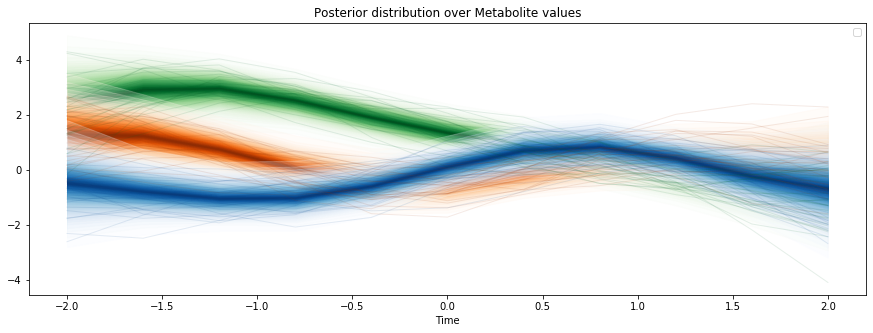

In [16]:
# Plotting 
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

# Plot over time with no disease status
plot_gp_dist(ax, 
             pred_samples["f_pred"][:,(X_new[:,1]==0) & (X_new[:,2]==1)], 
             X_new[(X_new[:,1]==0) & (X_new[:,2]==1),0],
             palette = 'Greens',
             fill_alpha = 0.25)
plot_gp_dist(ax, 
             pred_samples["f_pred"][:,(X_new[:,1]==0) & (X_new[:,3]==1)], 
             X_new[(X_new[:,1]==0) & (X_new[:,3]==1),0],
             palette = 'Oranges',
             fill_alpha = 0.25)
plot_gp_dist(ax, 
             pred_samples["f_pred"][:,(X_new[:,1]==0) & (X_new[:,4]==1)], 
             X_new[(X_new[:,1]==0) & (X_new[:,4]==1),0],
             palette = 'Blues',
             fill_alpha = 0.25)

# # Overlay observed data
# sns.scatterplot(data = df_sub.assign(id = df_sub_id.id),
#                 x = 'days_from_start',
#                 y = 'scaled_log_intensity',
#                 hue = 'id',
#                 s = 50);

# Specify labels and axes
plt.xlabel("Time")
# plt.ylim([-6, 6])
# plt.xlim([-4, 4])
plt.title("Posterior distribution over Metabolite values")
plt.legend();

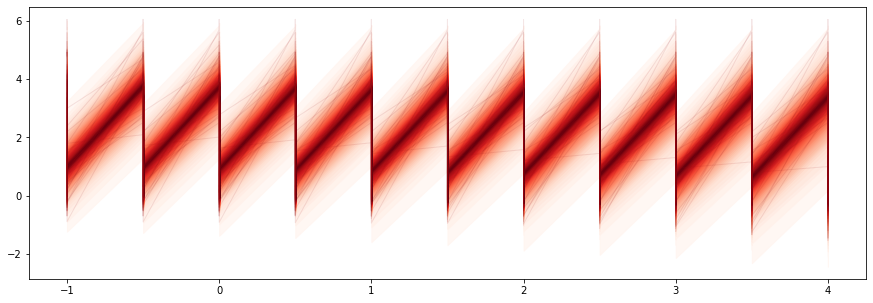

In [147]:
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

# Plot over time with no disease status
plot_gp_dist(ax, pred_samples["f_pred"], X_new[:,1])

No handles with labels found to put in legend.


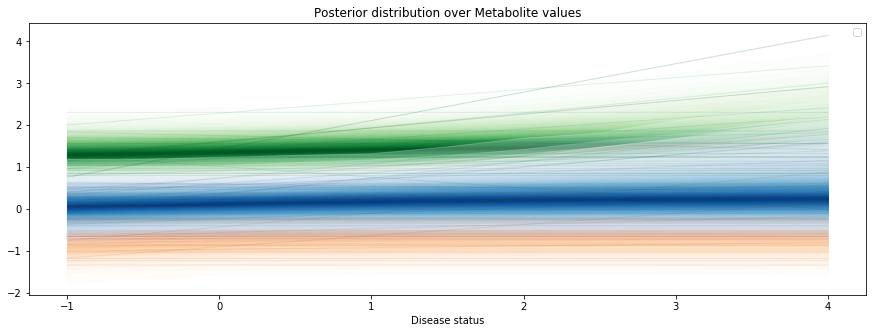

In [17]:
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

# Plot over time with no disease status
plot_gp_dist(ax, 
             pred_samples["f_pred"][:,(X_new[:,0]==0) & (X_new[:,2]==1)], 
             X_new[(X_new[:,0]==0) & (X_new[:,2]==1),1],
             palette = 'Greens',
             fill_alpha = 0.25)
plot_gp_dist(ax, 
             pred_samples["f_pred"][:,(X_new[:,0]==0) & (X_new[:,3]==1)], 
             X_new[(X_new[:,0]==0) & (X_new[:,3]==1),1],
             palette = 'Oranges',
             fill_alpha = 0.25)
plot_gp_dist(ax, 
             pred_samples["f_pred"][:,(X_new[:,0]==0) & (X_new[:,4]==1)], 
             X_new[(X_new[:,0]==0) & (X_new[:,4]==1),1],
             palette = 'Blues',
             fill_alpha = 0.25)

# # Overlay observed data
# sns.scatterplot(data = df_sub.assign(id = df_sub_id.id),
#                 x = 'days_from_start',
#                 y = 'scaled_log_intensity',
#                 hue = 'id',
#                 s = 50);

# Specify labels and axes
plt.xlabel("Disease status")
# plt.ylim([-6, 6])
# plt.xlim([-4, 4])
plt.title("Posterior distribution over Metabolite values")
plt.legend();

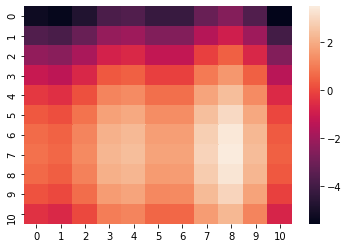

In [69]:
import seaborn as sns
sns.heatmap(pred_samples['f_pred'].mean(axis=0)[X_new[:,2]==1].reshape(len(np.unique(x1)), 
                                                                       len(np.unique(x2))))

In [221]:
# Can we show these together?
import plotly.graph_objects as go

fig = go.Figure(data =
    go.Contour(
        z = np.array([np.mean(pred_samples['f_pred'][:,i:(i+3)], axis=1) 
                      for i in range(100)]).mean(axis=1).reshape(10,10),
        #pred_samples['f_pred'].mean(axis=0).reshape(10,10),
        x = np.unique(x1),
        y = np.unique(x2),
        colorscale = 'Turbo'#'Aggrnyl'
    ),
               layout = go.Layout(
               title = 'Mean of Feature',
               yaxis_title = 'Disease Status',
               xaxis_title = 'Time'))
fig.show()